In [2]:
import pickle
import numpy as np

## Data preparation

In [3]:
data = pickle.load(open('../data/all_cropped_images_224.pkl','rb'))

In [4]:
cracks_label=np.zeros(700)
delaminations_lablel=np.ones(700)
erosions_label=np.ones(700)+1
lightning_strike=np.ones(700)+2
labels=np.concatenate((cracks_label,delaminations_lablel))
labels=np.concatenate((labels,erosions_label))
labels=np.concatenate((labels,lightning_strike))
print(labels.shape)
np.unique(labels)

(2800,)


array([0., 1., 2., 3.])

In [5]:
len(data) == len(labels)

True

## VGG19: Model Preparation

In [6]:
from keras.applications.vgg19 import VGG19
model = VGG19(include_top=False)
model.summary()

Using TensorFlow backend.
W0712 14:55:40.523953 140694921144064 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 14:55:40.559103 140694921144064 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 14:55:40.575194 140694921144064 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 14:55:40.620669 140694921144064 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0712 14:55:41.213055 1406949

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:
cnn_output=model.predict(data)

In [13]:
with open('all_cropped_images_224_precomputed_cnn_features_vgg19.pkl','wb') as f:
    pickle.dump(cnn_output, f)
print(cnn_output.shape)

(2800, 7, 7, 512)


In [7]:
cnn_output = pickle.load(open('all_cropped_images_224_precomputed_cnn_features_vgg19.pkl','rb'))
cnn_output.shape

(2800, 7, 7, 512)

## Fully-Connected Layer Tuning 

In [14]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential


def train_model_neural_net(X_train,Y_train,X_val,Y_val):
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)
    print(X_train.shape[1:])
    model = Sequential()
    #model.add(GlobalAveragePooling2D(input_shape=(2, 2, 512)))
    model.add(GlobalAveragePooling2D(input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model.fit(X_train,Y_train ,validation_data=(X_val,Y_val),epochs=50,shuffle=True,batch_size=256,callbacks=[es, mc], verbose=0)
    saved_model = load_model('best_model.h5')
    train_pred =saved_model.predict(X_train)            
    valid_pred =saved_model.predict(X_val)
    train_loss, train_acc = saved_model.evaluate(X_train,Y_train, verbose=0)
    val_loss, val_acc = saved_model.evaluate(X_val,Y_val, verbose=0)
    print('accuracy Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    print('loss Train: %.3f, Test: %.3f' % (train_loss, val_loss))
    #test_pred = saved_model.predict(X_test)
    return train_pred ,valid_pred,saved_model,val_acc,val_loss

def train_kfold_neural_net(X_train,Y_train,split=5):
    final_train_pred=np.zeros((X_train.shape[0],4))
    from sklearn.model_selection import StratifiedKFold
    kf =  StratifiedKFold(n_splits=split, shuffle=False)
    i=1
    score=0
    accuracies=np.array([])
    losses=np.array([])
    for train_index, val_index in kf.split(X_train, Y_train):
        print("fold:"+str(i))
        train_fold_features, val_fold_features = X_train[train_index], X_train[val_index]
        train_fold_target, val_fold_target = Y_train[train_index], Y_train[val_index] 
        
        train_pred ,valid_pred,model,val_acc,val_loss=train_model_neural_net( 
                                                        X_train=train_fold_features,
                                                        Y_train= train_fold_target,
                                                        X_val= val_fold_features,
                                                        Y_val= val_fold_target
                                                    )
        accuracies=np.append(accuracies,val_acc)
        losses=np.append(losses,val_loss)
        final_train_pred[val_index]=valid_pred
        i=i+1
    avg_acc=accuracies.sum() / 5
    avg_loss=losses.sum() / 5
    print('overall performance avg_acc: %.3f, avg_loss: %.3f' % (avg_acc, avg_loss))
    return final_train_pred,model,avg_acc,avg_loss

final_train_pred,model,avg_acc,avg_loss=train_kfold_neural_net(cnn_output,Y_train=labels,split=5)

fold:1
(7, 7, 512)
accuracy Train: 0.925, Test: 0.843
loss Train: 0.266, Test: 0.516
fold:2
(7, 7, 512)
accuracy Train: 0.913, Test: 0.821
loss Train: 0.297, Test: 0.566
fold:3
(7, 7, 512)
accuracy Train: 0.921, Test: 0.836
loss Train: 0.257, Test: 0.570
fold:4
(7, 7, 512)
accuracy Train: 0.900, Test: 0.825
loss Train: 0.318, Test: 0.521
fold:5
(7, 7, 512)
accuracy Train: 0.923, Test: 0.804
loss Train: 0.297, Test: 0.669
overall performance avg_acc: 0.826, avg_loss: 0.568


## Confusion Matrix

Confusion matrix, without normalization


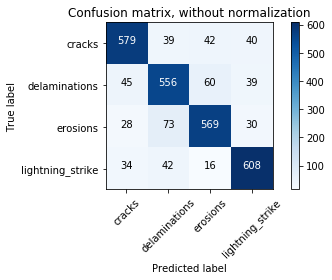

In [15]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
stat_pred=pd.DataFrame()
stat_pred["pred"]=np.argmax(final_train_pred,axis=1)
stat_pred["true"]=labels
stat_pred.true=stat_pred.true.astype('int8')
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(stat_pred.true.values, stat_pred.pred.values, labels=[0,1,2,3])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['cracks','delaminations','erosions','lightning_strike'],
                      title='Confusion matrix, without normalization')